In [2]:
## Import all the necessary files modules and routines
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import pandas as pd
import pickle as pkl
tensorflow.keras.backend.clear_session()
from tensorflow.keras.layers import Concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers import Input, add
from keras.models import Model
from matplotlib import image
from matplotlib import pyplot
from ipywidgets import interact
import matplotlib.pyplot as plt
from skimage.transform import resize
from numpy import genfromtxt
from tensorflow.keras.utils import to_categorical

In [3]:

## Import Low Resolution images as np array and split in (32*32) format 

Y=np.load('../input/dataset-new/Lowres.npy',allow_pickle=True)

x_original=np.split(Y,945)


# Plotting images for easy visualization of Structures
def plot_bridge(i):
    fig,ax = pyplot.subplots()
    im = pyplot.imshow(x_original[i], cmap='gray_r')
    pyplot.axis('off')
    
    pyplot.show()

interact(plot_bridge, i=(0, len(x_original)-1))


interactive(children=(IntSlider(value=472, description='i', max=944), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bridge(i)>

In [4]:
X_input=np.array(x_original)

In [5]:
X=np.array(x_original)
print(X.shape)
a=np.zeros((1,33))
#print(X)
X= np.insert(X, 0, 1, axis=2)
print(X[944])
print(X.shape)

(945, 32, 32)
[[1.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.66022826e-024
  4.29723780e-078 5.42851756e-139]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.95725947e-003
  6.60582554e-021 3.13988470e-072]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 ... 5.54645836e-003
  2.18239727e-003 1.88687556e-014]
 ...
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.00000000e+000
  1.00000000e+000 1.00000000e+000]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.00000000e+000
  1.00000000e+000 1.00000000e+000]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.00000000e+000
  1.00000000e+000 1.00000000e+000]]
(945, 32, 33)


In [6]:
# Creating zero valued multi- dimensional array of dimension (945*33*33) to accomdate Boundary conditions.
X_data=np.zeros((945,33,33))
print(a.shape)
for i in range(945):
    X_data[i]=np.append(X[i],a,axis=0)
#print(X_data[944])
print(X_data.shape)

(1, 33)
(945, 33, 33)


In [7]:
# Creating a channel for consideration of X-directional fixed BC

X_data3=np.expand_dims(X_data,axis=3)
print(X_data3.shape)

(945, 33, 33, 1)


In [8]:
# Creating a channel for consideration of Y-directional fixed BC

X_data4=X_data3
print(X_data4.shape)

(945, 33, 33, 1)


In [9]:
#Creating a channel for consideration of X-directional force BC

X_data1_temp= np.insert(x_original, 0, 0, axis=2)
#print(X_data1_temp[1])

X_data1=np.zeros((945,33,33))
for i in range(945):
    X_data1[i]=np.append(X_data1_temp[i],a,axis=0)
#print(X_data1.shape)


In [10]:
#Creating a channel for consideration of Y-directional force BC

X_data2 = X_data1
for i in range(945):
    X_data2[i][32][32]=1

#print(X_data2[944])
X_data2=np.expand_dims(X_data2,axis=3)
print(X_data2.shape)

(945, 33, 33, 1)


In [11]:
X_data1=np.expand_dims(X_data1,axis=3)
print(X_data1.shape)

(945, 33, 33, 1)


In [12]:
#Concatenating all the individual channels (BCs) into one, creating final input 

X_final= np.concatenate((X_data1, X_data2,X_data3,X_data4),axis=3)
print(X_final.shape)

(945, 33, 33, 4)


In [13]:
#Importing Volume fraction 

my_data = genfromtxt('../input/dataset-new/input.csv', delimiter=',')[:,2]
my_data = my_data[0:945]
print(my_data[30:40])


[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


**CNN AUTOENCODER**

In [14]:
# Creating volume fraction data

X_data_parent=np.ones((105,4,4,1))
#print(X_data_parent)
a1 = X_data_parent*0.1
a2= X_data_parent*0.2
a3= X_data_parent*0.3
a4= X_data_parent*0.4
a5= X_data_parent*0.5
a6= X_data_parent*0.6
a7= X_data_parent*0.7
a8= X_data_parent*0.8
a9= X_data_parent*0.9
abc=np.concatenate((a1,a2,a3,a4,a5,a6,a7,a8,a9),axis=0)

print(abc.shape)



(945, 4, 4, 1)


In [15]:
#Creating encoder-decoder model

start = Input(shape=(33, 33 ,4)) 

#ENCODER
conv1_1= Conv2D(64,(2,2),activation ='relu',strides=(1,1))(start)
conv1_2= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv1_1)
pool1= MaxPooling2D(pool_size=(2,2))(conv1_2)
conv1_3= Conv2D(128,(3,3),padding = "same",activation ='relu',strides=(1,1))(pool1)
conv1_4= Conv2D(128,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv1_3)
pool2= MaxPooling2D(pool_size=(2,2))(conv1_4)
conv1_5= Conv2D(256,(3,3),padding = "same",activation ='relu',strides=(1,1))(pool2)
conv1_6= Conv2D(256,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv1_5)
pool3= MaxPooling2D(pool_size=(2,2))(conv1_6)
h= Conv2D(512,(3,3),strides=(1, 1),padding = 'same',activation ='relu')(pool3)

label=Input(shape=(4,4,1))
# merge latent space with label
#conv_ae.add(concatenate([my_data]))
lat=Concatenate()([h,label])



#DECODER

conv2_1= Conv2D(512,(3,3),padding="same",activation ='relu',strides=(1,1))(lat)
up1= UpSampling2D(size=(2,2))(conv2_1)
conv2_2= Conv2D(256,(3,3),padding = "same",activation ='relu',strides=(1,1))(up1)
conv2_3= Conv2D(256,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv2_2)
up2= UpSampling2D(size=(2,2))(conv2_3)
conv2_4= Conv2D(128,(3,3),padding = "same",activation ='relu',strides=(1,1))(up2)
conv2_5= Conv2D(128,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv2_4)
up3= UpSampling2D(size=(2,2))(conv2_5)
conv2_6= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(up3)
conv2_7= Conv2D(2,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv2_6)
r= Conv2D(1,(3,3),padding = "same",activation ='sigmoid',strides=(1,1))(conv2_7)



2022-10-08 16:25:16.176253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 16:25:16.284939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 16:25:16.285667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 16:25:16.287053: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
#Assigning inputs and outputs to the autoencoder model and compiling the same

autoencoder = Model(inputs=[start,label], outputs=r)
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 33, 33, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [17]:
# test train split of training and validation data

images_train, images_test,abc_train,abc_test = train_test_split(X_final,abc,train_size= 0.8,test_size=0.20,shuffle=False)
print(images_train.shape)
print(abc_train.shape)

X_input_train = X_input[:756]
print(X_input_train.shape)
X_input_test = X_input[756:]
print(X_input_test.shape)





(756, 33, 33, 4)
(756, 4, 4, 1)
(756, 32, 32)
(189, 32, 32)


In [18]:
# Assigning Hyperparameters (batch size and epochs) and training the model

epochs = 12
batch_size = 50

history = autoencoder.fit([images_train,abc_train], X_input_train , batch_size=batch_size, epochs=epochs,verbose=1, validation_data=([images_test,abc_test],X_input_test))

Epoch 1/12


2022-10-08 16:25:19.809159: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-08 16:25:21.708242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


16/16 [==============================] - 9s 80ms/step - loss: 0.2936 - val_loss: 0.1265
Epoch 2/12
16/16 [==============================] - 0s 23ms/step - loss: 0.1639 - val_loss: 0.1248
Epoch 3/12
16/16 [==============================] - 0s 23ms/step - loss: 0.0684 - val_loss: 0.1096
Epoch 4/12
16/16 [==============================] - 0s 23ms/step - loss: 0.0649 - val_loss: 0.0491
Epoch 5/12
16/16 [==============================] - 0s 23ms/step - loss: 0.0450 - val_loss: 0.0537
Epoch 6/12
16/16 [==============================] - 0s 23ms/step - loss: 0.0295 - val_loss: 0.0309
Epoch 7/12
16/16 [==============================] - 0s 23ms/step - loss: 0.0249 - val_loss: 0.0448
Epoch 8/12
16/16 [==============================] - 0s 25ms/step - loss: 0.0219 - val_loss: 0.0439
Epoch 9/12
16/16 [==============================] - 0s 23ms/step - loss: 0.0215 - val_loss: 0.0257
Epoch 10/12
16/16 [==============================] - 0s 26ms/step - loss: 0.0187 - val_loss: 0.0337
Epoch 11/12
16/16 [=

###### Predicting on test data

decoded_imgs = autoencoder.predict([images_test, abc_test])



In [19]:
decoded_imgs = autoencoder.predict([images_test, abc_test])

In [20]:
#Plotting interactive images of predicted images on test_data


def plot_bridge(i):
    fig,ax = pyplot.subplots()
    
    #print(f"Volume fraction: {y[i]}")
    im = pyplot.imshow(decoded_imgs[i].reshape(32,32), cmap='gray_r')
    pyplot.axis('off')
    
    pyplot.show()

interact(plot_bridge, i=(0, len(decoded_imgs)-1))




interactive(children=(IntSlider(value=94, description='i', max=188), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bridge(i)>

In [21]:
#Plotting interactive images of original images(ground truth) on test_data


def plot_bridge1(i):
    fig,ax = pyplot.subplots()
    
    #print(f"Volume fraction: {y[i]}")
    im1 = pyplot.imshow(X_input_test[i].reshape(32,32), cmap='gray_r')
    pyplot.axis('off')
    
    pyplot.show()
 
 
interact(plot_bridge1, i=(0, len(X_input_test)-1))

interactive(children=(IntSlider(value=94, description='i', max=188), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bridge1(i)>

dict_keys(['loss', 'val_loss'])


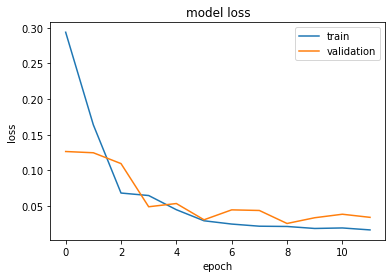

In [22]:
#Plotting training and validation losses against epoch

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## GAN 

Generator module


In [23]:
#Importing all the necessary modules and routines for GAN

import tensorflow as tf
from tensorflow import keras
from PIL import Image
from PIL.ImageColor import getrgb
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, Flatten
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import shutil
import datetime
%load_ext tensorboard

In [24]:
#Predicting on full data set as it will be input to GAN

input_GAN = autoencoder.predict([X_final,abc])

def plot_bridge3(i):
    fig,ax = pyplot.subplots()
    
    #print(f"Volume fraction: {y[i]}")
    im3 = pyplot.imshow(input_GAN[i].reshape(32,32), cmap='gray_r')
    pyplot.axis('off')
    
    pyplot.show()
 
 
interact(plot_bridge3, i=(0, len(input_GAN)-1))

interactive(children=(IntSlider(value=472, description='i', max=944), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bridge3(i)>

In [25]:
#Building generator network


def build_generator():
   
    residual_blocks = 16
    input_shape = (32, 32, 1)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    conv1_GeN = Conv2D(64,(5,5),activation ='relu',padding='same',strides=(1,1))(input_layer)

    

    # Add the post-residual block

    conv2_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv1_GeN)
    conv3_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv2_GeN)
    conv4_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv3_GeN)
    conv5_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv4_GeN)
    conv6_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv5_GeN)
    conv7_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv6_GeN)
    conv8_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv7_GeN)
    conv9_GeN= Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv8_GeN)

    conv10_GeN = Conv2D(64,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv9_GeN)
    Residual_inter_output= BatchNormalization(momentum = 0.8)(conv10_GeN)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    Residual_output = Add()([Residual_inter_output, conv1_GeN])

    # Add an upsampling block
    conv11_GeN = UpSampling2D(size=(2,2))(Residual_output) 
    conv12_GeN= Conv2D(256,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv11_GeN)
    
    
    # Add another upsampling block
    conv13_GeN = UpSampling2D(size=(2,2))(conv12_GeN)
    conv14_GeN= Conv2D(256,(3,3),padding = "same",activation ='relu',strides=(1,1))(conv13_GeN)

    # Output convolution layer
    conv15_GeN= Conv2D(1,(5,5),padding = "same",activation ='sigmoid',strides=(1,1))(conv14_GeN)


    # Keras model
    model = Model(inputs=[input_layer], outputs=[conv15_GeN], name='generator')
    return model

In [26]:
#Building discriminator network

def build_discriminator():
  
    leakyrelu_alpha = 0.2
    input_shape = (128,128,2)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(64,(3,3), strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(64,(3,3), strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum = 0.8)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(128,(3,3), strides=1,padding = 'same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum = 0.8)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(128,(3,3), strides=2, padding = 'same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum = 0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256,(3,3), strides=1,padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum = 0.8)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(256,(3,3), strides=2, padding = 'same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum = 0.8)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(512,(3,3), strides=1,padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum = 0.8)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(512,(3,3), strides=2, padding = 'same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum = 0.8)(dis8)

    # Add a dense layer
    #avgd = keras.layers.AveragePooling2D(pool_size=(4,4) , strides = (4,4))(dis8)

    flat = keras.layers.Flatten()(dis8)
    dis9 = Dense(units=1024)(flat)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [27]:
# Importing Pretrained weights of Imagenet data set in VGG19 architecture at 13th layer

def build_vgg():
    """
    Build VGG network to extract image features
    """
    grayImage = (128,128,3)
    #dummy_RGB_images[:, :, :, 0] = train_gray_images[:, :, :, 0]
#dummy_RGB_images[:, :, :, 1] = train_gray_images[:, :, :, 0]
#dummy_RGB_images[:, :, :, 2] = train_gray_images[:, :, :, 0]

    vgg = keras.applications.VGG19(include_top = False ,  input_shape = grayImage , weights="imagenet")
    features = vgg.get_layer(index = 13).output
    #features = vgg.output
    model = keras.Model(inputs=[vgg.inputs], outputs=[features])
    return model

        




### Model

In [67]:
# Building Adverserial (combination of gnerator and discriminator) network


mode = 'train'

epochs = 30
batch_size = 20

common_optimizer = Adam(0.0002, 0.5)
low_resolution_shape = (32, 32, 1)
high_resolution_shape = (128, 128,1)




#rgbImage=np.concatenate((high_resolution_shape,high_resolution_shape,high_resolution_shape))


#print(rgbImage.shape)

vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss='mae', optimizer=common_optimizer, metrics=['accuracy'])

# Build and compile the discriminator network
discriminator = build_discriminator()
discriminator.compile(loss='mae', optimizer=common_optimizer, metrics=['accuracy'])

# Build the generator network
generator = build_generator()

"""
Build and compile the adversarial model
"""

# Input layers for high-resolution and low-resolution images
input_high_resolution = Input(shape=high_resolution_shape)
input_low_resolution = Input(shape=low_resolution_shape)
#Input_final_to_discriminator=Input(shape=Input_to_discriminator)



# Generate high-resolution images from low-resolution images
generated_high_resolution_images = generator(input_low_resolution)



rgbImage=Concatenate()([generated_high_resolution_images,generated_high_resolution_images,generated_high_resolution_images])

# Extract feature maps of the generated images
features = vgg(rgbImage)

# Freeze the discriminator for while training the adversarial model
discriminator.trainable = False

final_input_to_discriminator=Concatenate()([input_high_resolution,input_high_resolution])
# Get the probability of generated high-resolution images
probs = discriminator(final_input_to_discriminator)



# Create and compile an adversarial model
adversarial_model = Model([input_low_resolution, input_high_resolution], [probs,features])
adversarial_model.compile(loss=['binary_crossentropy', 'mae'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

generator.summary()
discriminator.summary()
adversarial_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 32, 32, 64)   1664        input_45[0][0]                   
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 32, 32, 64)   36928       conv2d_191[0][0]                 
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 32, 32, 64)   36928       conv2d_192[0][0]                 
__________________________________________________________________________________________

In [68]:
#Importing high reolution images(ground truth) and splitting data for training and testing


low_resolution_images = input_GAN
inverted_high_resolution_img =np.load('../input/dataset-new/High_res.npy',allow_pickle=True)


#inverted_high_resolution_img = np.invert(high_resolution_images)

low_resolution_images_train,low_resolution_images_test,inverted_high_resolution_img_train,inverted_high_resolution_img_test = train_test_split(low_resolution_images,inverted_high_resolution_img,train_size= 0.8,test_size=0.20,shuffle=False)
print(low_resolution_images_train.shape)
print(inverted_high_resolution_img_test.shape)
print(low_resolution_images.shape)

(756, 32, 32, 1)
(189, 128, 128)
(945, 32, 32, 1)


In [69]:
#temporary modification of ground truth data to be passed in VGG19 network


inverted_high_resolution_img1=np.expand_dims(inverted_high_resolution_img_train,axis=3)
inverted_high_resolution_img2=np.concatenate((inverted_high_resolution_img1,inverted_high_resolution_img1,inverted_high_resolution_img1),axis=3)


#UPSCALING OF 32x32: 
resized_low_resolution_image = resize(low_resolution_images, (945,128,128,1),order =0,preserve_range=True, anti_aliasing=False)
print(resized_low_resolution_image.shape)
print(inverted_high_resolution_img.shape)
expanded = np.expand_dims(inverted_high_resolution_img,axis=3)
discrim_realdata= np.concatenate((resized_low_resolution_image,expanded),axis=3)
print(discrim_realdata.shape)
discrim_realdata_train=discrim_realdata[:756]
print(discrim_realdata_train.shape)
discrim_realdata_test=discrim_realdata[756:]
print(discrim_realdata_test.shape)

#SPLIT THE RESIZED DATA TO TRAIN AND TEST
resized_low_resolution_image_train = resized_low_resolution_image[:756]
resized_low_resolution_image_test = resized_low_resolution_image[756:]
print(resized_low_resolution_image_train.shape)
print(resized_low_resolution_image_test.shape)


#def plot_bridge7(i):
#    fig,ax = pyplot.subplots()
#    
#   #print(f"Volume fraction: {y[i]}")
#    im7 = pyplot.imshow(inverted_high_resolution_img[i].reshape(128,128), cmap='gray_r')
#    pyplot.axis('off')
#    
#    pyplot.show()
 
 
 
#interact(plot_bridge7, i=(0, len(inverted_high_resolution_img)-1))
#print(discrim_realdata[0:1])

(945, 128, 128, 1)
(945, 128, 128)
(945, 128, 128, 2)
(756, 128, 128, 2)
(189, 128, 128, 2)
(756, 128, 128, 1)
(189, 128, 128, 1)


In [70]:
# Training Adverserial Model


def just_train():
    
    #low_resolution_images = input_GAN
    #dataloader_l = iter(input_pipeline(low_resolution_images,20))
    #high_resolution_images =np.load('High_res.npy',allow_pickle=True)
    #dataloader_h = iter(input_pipeline(high_resolution_images,20))
    # Build and compile VGG19 network to extract features
    train_batches = int(np.ceil(len(low_resolution_images_train)/batch_size))-1
    
    for epoch in range(epochs):
        
        
        for i in  range(train_batches):
            
            
            
            beg = i*batch_size
            end = (i+1)*batch_size

          

                          # Generate high-resolution images from low-resolution images
            generated_high_resolution_images = generator.predict(low_resolution_images_train[beg:end])
            discrim_fakedata = np.concatenate((resized_low_resolution_image_train[beg:end],generated_high_resolution_images),axis=3)
                          # Generate batch of real and fake labels

                          #real_labels = np.ones((batch_size, 16, 16, 1))
                          #fake_labels = np.zeros((batch_size, 16, 16, 1))

            real_labels = np.ones((batch_size, 1))*0.95
            fake_labels = np.ones((batch_size,  1))*0.05
                          #print(real_labels.shape)



                          # Train the discriminator network on real and fake images
            d_loss_real = discriminator.train_on_batch(discrim_realdata[beg:end], real_labels)
            d_loss_fake = discriminator.train_on_batch(discrim_fakedata, fake_labels)

                          # Calculate total discriminator loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                      #print("d_loss:", d_loss)

                  #print(high_resolution_images.shape)
                  #high_resolution_images =np.load('High_res.npy',allow_pickle=True)
                  #print(high_resolution_images.shape)

                  #print(high_resolution_images1.shape)

                  #print(high_resolution_images2.shape)
                  # Sample a batch of images
                  #high_resolution_images, low_resolution_images = next(highres_dataloader) , next(lowres_dataloader)


             # "Train the generator network"


                  # Sample a batch of images

                  #high_resolution_images, low_resolution_images = sample_images(batch_size)
                  #high_resolution_images, low_resolution_images = next(highres_dataloader) , next(lowres_dataloader)
                  #high_resolution_images, low_resolution_images = next(dataloader)


                  #high_resolution_images=np.Concatenate(high_resolution_images,high_resolution_images,high_resolution_images,axis=3)



                  # Extract feature maps for real high-resolution images
                  #rgbImage1=np.concatenate(high_resolution_images,high_resolution_images,generated_high_resolution_images)
            image_features = vgg.predict(inverted_high_resolution_img2[beg:end])

                  # Train the generator network
            g_loss = adversarial_model.train_on_batch([low_resolution_images_train[beg:end],inverted_high_resolution_img_train[beg:end]], [real_labels,image_features])

                  #print("g_loss:", g_loss)

        print("Epoch {} : g_loss: {} , d_loss: {}".format(epoch , g_loss[0] , d_loss[0]))

                  # Write the losses to Tensorboard
                  #write_log(tensorboard, 'g_loss', g_loss[0], epoch)
                  #write_log(tensorboard, 'd_loss', d_loss[0], epoch)

                  # Sample and save images after every 100 epochs

                  #with writer.as_default():
                   ## tf.summary.scalar('g_loss', g_loss[0], step=epoch)
                   # tf.summary.scalar('d_loss', d_loss[0], step=epoch)
                  #writer.flush()

                  #write_log(tensorboard, 'g_loss', g_loss[0], epoch)
                  #write_log(tensorboard, 'd_loss', d_loss[0], epoch)

                  #print("Epoch {}:  Gloss : {} , Dloss {}".format(epoch+1 , g_loss , d_loss))
            #if (epoch) % 100 == 0:
                      #high_resolution_images, low_resolution_images = sample_images(batch_size)
                      #high_resolution_images, low_resolution_images = next(highres_dataloader) , next(lowres_dataloader)
                      #high_resolution_images, low_resolution_images = next(dataloader)

                      # Normalize images
                      #high_resolution_images = high_resolution_images / 127.5 - 1.
                      #low_resolution_images = low_resolution_images / 127.5 - 1.

            # generated_images = generator.predict_on_batch(low_resolution_images_test[beg:end])

                       # for index, img in enumerate(generated_images):
                         #      save_images(res_im_path + "img_{}_{}".format(epoch, index),
                         #                 low_resolution_images[index], generated_images[index] , high_resolution_images[index]
                         #                 )


                #if (epoch) % 1000 == 0:
                      # Save models
                   #     generator.save_weights("generator_{}.h5".format(epoch))
                     #   discriminator.save_weights("discriminator_{}.h5".format(epoch))

              

              
if mode == 'train':
     just_train()

    
    
    

Epoch 0 : g_loss: 414.25677490234375 , d_loss: 0.05000000633299351
Epoch 1 : g_loss: 413.69342041015625 , d_loss: 0.05000000633299351
Epoch 2 : g_loss: 413.893798828125 , d_loss: 0.05000000633299351
Epoch 3 : g_loss: 413.70733642578125 , d_loss: 0.05000000633299351
Epoch 4 : g_loss: 413.566162109375 , d_loss: 0.05000000633299351
Epoch 5 : g_loss: 413.54205322265625 , d_loss: 0.05000000633299351
Epoch 6 : g_loss: 413.55230712890625 , d_loss: 0.05000000633299351
Epoch 7 : g_loss: 413.5270080566406 , d_loss: 0.05000000633299351
Epoch 8 : g_loss: 413.4330139160156 , d_loss: 0.05000000633299351
Epoch 9 : g_loss: 413.3768005371094 , d_loss: 0.05000000633299351
Epoch 10 : g_loss: 413.43438720703125 , d_loss: 0.05000000633299351
Epoch 11 : g_loss: 413.412841796875 , d_loss: 0.05000000633299351
Epoch 12 : g_loss: 413.38140869140625 , d_loss: 0.05000000633299351
Epoch 13 : g_loss: 413.36700439453125 , d_loss: 0.05000000633299351
Epoch 14 : g_loss: 413.3606872558594 , d_loss: 0.05000000633299351


In [71]:
# Predict on test data and plotting interactively

generated_images = generator.predict(low_resolution_images_test)


def plot_bridge4(i):
    fig,ax = pyplot.subplots()
    
    #print(f"Volume fraction: {y[i]}")
    im4 = pyplot.imshow(generated_images[i].reshape(128,128), cmap='gray')
    pyplot.axis('off')
    
    pyplot.show()

interact(plot_bridge4, i=(0, len(generated_images)-1))


interactive(children=(IntSlider(value=94, description='i', max=188), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bridge4(i)>

In [76]:

img1=Image.fromarray(generated_images[0].reshape(128,128))
img1.save('./GAN_1.tiff')
img1=Image.fromarray(generated_images[94].reshape(128,128))
img1.save('./GAN_95.tiff')
img1=Image.fromarray(generated_images[188].reshape(128,128))
img1.save('./GAN_189.tiff')

In [55]:
# Plotting interactively Original images (ground truth) for comparison


def plot_bridge5(i):
    fig,ax = pyplot.subplots()
    
    #print(f"Volume fraction: {y[i]}")
    im1 = pyplot.imshow(inverted_high_resolution_img_test[i].reshape(128,128), cmap='gray')
    pyplot.axis('off')
    
    pyplot.show()
 
 
interact(plot_bridge5, i=(0, len(inverted_high_resolution_img_test)-1))

interactive(children=(IntSlider(value=94, description='i', max=188), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bridge5(i)>

In [3]:
import torch
import torch.nn as nn

MSE_loss_fn = nn.MSELoss()

high_resolution_img_test_new=np.expand_dims(high_resolution_images_test,axis=3)

print(generated_images.shape)

print(high_resolution_img_test_new.shape)

#loss_value = MSE_loss_fn(generated_images,high_resolution_img_test_new)
data1 = torch.from_numpy(generated_images)
data2 = torch.from_numpy(high_resolution_img_test_new)

Loss_value = MSE_loss_fn(data2, data1)

print(Loss_value)

NameError: name 'np' is not defined

In [149]:
import cv2
import image_similarity_measures
from image_similarity_measures.quality_mtrics import rmse, psnr
image-similarity-measures --org_img_path=path_to_first_img
--pred_img_path=path_to_second_img --mode=tif
out_rmse = rmse(high_resolution_img_test_new[0], generated_images[0])
out_psnr = psnr(high_resolution_img_test_new[0], generated_images[0])

SyntaxError: can't assign to operator (1352205111.py, line 4)